# Notebook 03c | Modelagem Prophet com Validação de Janela Crescente

**Objetivos:**
- Aplicar modelo Prophet em série mensal agregada de vendas  
- Usar validação temporal do tipo **Expanding Window** em três folds:  
  1. Treino: Jan/2016 → Dez/2018 | Validação: Jan/2019 → Jun/2019  
  2. Treino: Jan/2016 → Jun/2019 | Validação: Jul/2019 → Dez/2019  
  3. Treino: Jan/2016 → Dez/2019 | Validação: Jan/2020 → Fev/2020  
- Avaliar desempenho em cada fold (MAE, RMSE, R²)

## 1. Configuração do Ambiente

Inicializar Spark, importar bibliotecas e definir caminho dos dados Gold mensais.

In [0]:
# Instalar prophet
%pip install scikit-learn prophet

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# Importações e setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# Funções de métricas
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot != 0 else np.nan

# Inicializar Spark
spark = SparkSession.builder.getOrCreate()
gold_monthly_path = "/FileStore/gold/sales_monthly_gold"


## 2. Leitura e Preparação dos Dados

Carregar o Parquet via Spark, converter para pandas e renomear colunas para Prophet.


In [0]:
# Carregar dados Gold mensal
df_spark = (
    spark.read
         .format("parquet")
         .load(gold_monthly_path)
         .withColumn("month_start", to_date("month_start"))
)

# Converter para pandas e garantir datetime
df = df_spark.toPandas()
df['ds'] = pd.to_datetime(df['month_start'])
df['y']  = df['total_sales_usd'].astype(float)

# Manter apenas colunas necessárias e ordenar
df = df[['ds', 'y']].sort_values('ds').reset_index(drop=True)


## 3. Validação de Janela Crescente (Expanding Window)
- **Fold 1**: Treino até Dez/2018 · Validação Jan–Mar/2019  
- **Fold 2**: Treino até Mar/2019 · Validação Abr–Jun/2019  
- **Fold 3**: Treino até Jun/2019 · Validação Jul–Set/2019  
- **Fold 4**: Treino até Set/2019 · Validação Out–Dez/2019  
- **Fold 5**: Treino até Dez/2019 · Validação Jan–Mar/2020  
- **Fold 6**: Treino até Mar/2020 · Validação Abr–Jun/2020  
- **Fold 7**: Treino até Jun/2020 · Validação Jul–Set/2020  

### 3.1 Sem feriados


In [0]:
# Definição dos três folds de Expanding Window
folds = [
    ("2018-12-01", "2019-01-01", "2019-03-01"),
    ("2019-03-01", "2019-04-01", "2019-06-01"),
    ("2019-06-01", "2019-07-01", "2019-09-01"),
    ("2019-09-01", "2019-10-01", "2019-12-01"),
    ("2019-12-01", "2020-01-01", "2020-03-01"),
    ("2020-03-01", "2020-04-01", "2020-06-01"),
    ("2020-06-01", "2020-07-01", "2020-09-01"),
]

results = []

for i, (train_end, val_start, val_end) in enumerate(folds, start=1):
    train = df[df['ds'] <= train_end]
    val   = df[(df['ds'] >= val_start) & (df['ds'] <= val_end)]
    
    model = Prophet(yearly_seasonality=True)
    model.fit(train)
    
    # Previsão apenas nas datas de validação
    forecast = model.predict(val[['ds']])
    
    # Merge para alinhar y e yhat
    df_pred = (
        val[['ds','y']]
        .merge(forecast[['ds','yhat']], on='ds', how='inner')
        .sort_values('ds')
    )
    y_true = df_pred['y'].values
    y_pred = df_pred['yhat'].values
    
    results.append({
        "Fold":       f"Fold {i}",
        "Treino até": train_end,
        "Validação":  f"{val_start} → {val_end}",
        "MAE":        round(mae(y_true, y_pred), 2),
        "RMSE":       round(rmse(y_true, y_pred), 2),
        "R²":         round(r2(y_true, y_pred), 4)
    })

metrics_df = pd.DataFrame(results)
display(metrics_df)

18:38:32 - cmdstanpy - INFO - Chain [1] start processing
18:38:32 - cmdstanpy - INFO - Chain [1] done processing
18:38:32 - cmdstanpy - INFO - Chain [1] start processing
18:38:32 - cmdstanpy - INFO - Chain [1] done processing
18:38:32 - cmdstanpy - INFO - Chain [1] start processing
18:38:32 - cmdstanpy - INFO - Chain [1] done processing
18:38:32 - cmdstanpy - INFO - Chain [1] start processing
18:38:33 - cmdstanpy - INFO - Chain [1] done processing
18:38:33 - cmdstanpy - INFO - Chain [1] start processing
18:38:33 - cmdstanpy - INFO - Chain [1] done processing
18:38:33 - cmdstanpy - INFO - Chain [1] start processing
18:38:33 - cmdstanpy - INFO - Chain [1] done processing
18:38:33 - cmdstanpy - INFO - Chain [1] start processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing


Fold,Treino até,Validação,MAE,RMSE,R²
Fold 1,2018-12-01,2019-01-01 → 2019-03-01,307354.86,327447.07,0.656
Fold 2,2019-03-01,2019-04-01 → 2019-06-01,470928.29,480365.28,0.4384
Fold 3,2019-06-01,2019-07-01 → 2019-09-01,84953.72,129083.4,-3.989
Fold 4,2019-09-01,2019-10-01 → 2019-12-01,177906.71,180407.35,0.7928
Fold 5,2019-12-01,2020-01-01 → 2020-03-01,422691.18,577177.11,0.3152
Fold 6,2020-03-01,2020-04-01 → 2020-06-01,932662.44,942355.77,-9.6918
Fold 7,2020-06-01,2020-07-01 → 2020-09-01,1185800.36,1193718.07,-455.7069


In [0]:
# Definição dos três folds de Expanding Window
folds = [
    ("2018-12-01", "2019-01-01", "2019-03-01"),
    ("2019-03-01", "2019-04-01", "2019-06-01"),
    ("2019-06-01", "2019-07-01", "2019-09-01"),
    ("2019-09-01", "2019-10-01", "2019-12-01"),
    ("2019-12-01", "2020-01-01", "2020-03-01"),
    ("2020-03-01", "2020-04-01", "2020-06-01"),
    ("2020-06-01", "2020-07-01", "2020-09-01"),
]

results_holidays = []
for i, (train_end, val_start, val_end) in enumerate(folds, start=1):
    train = df[df['ds'] <= train_end]
    val   = df[(df['ds'] >= val_start) & (df['ds'] <= val_end)]
    
    model = Prophet(yearly_seasonality=True)
    model.add_country_holidays(country_name='US')
    model.fit(train)
    
    # Previsão apenas nas datas de validação
    forecast = model.predict(val[['ds']])
    
    # Merge para alinhar y e yhat
    df_pred = (
        val[['ds','y']]
        .merge(forecast[['ds','yhat']], on='ds', how='inner')
        .sort_values('ds')
    )
    y_true = df_pred['y'].values
    y_pred = df_pred['yhat'].values
    
    results_holidays.append({
        "Fold":       f"Fold {i}",
        "Treino até": train_end,
        "Validação":  f"{val_start} → {val_end}",
        "MAE":        round(mae(y_true, y_pred), 2),
        "RMSE":       round(rmse(y_true, y_pred), 2),
        "R²":         round(r2(y_true, y_pred), 4)
    })

metrics_df = pd.DataFrame(results_holidays)
display(metrics_df)

18:38:34 - cmdstanpy - INFO - Chain [1] start processing
18:38:34 - cmdstanpy - INFO - Chain [1] done processing
18:38:34 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:35 - cmdstanpy - INFO - Chain [1] done processing
18:38:35 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
18:38:36 - cmdstanpy - INFO - Chain [1] start processing
18:38:36 - cmdstanpy - INFO - Chain [1] done processing
18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1] done processing


Fold,Treino até,Validação,MAE,RMSE,R²
Fold 1,2018-12-01,2019-01-01 → 2019-03-01,285895.51,315223.09,0.6812
Fold 2,2019-03-01,2019-04-01 → 2019-06-01,456429.08,464997.47,0.4737
Fold 3,2019-06-01,2019-07-01 → 2019-09-01,113565.18,150009.75,-5.7378
Fold 4,2019-09-01,2019-10-01 → 2019-12-01,129924.65,131051.0,0.8907
Fold 5,2019-12-01,2020-01-01 → 2020-03-01,414401.73,585780.49,0.2946
Fold 6,2020-03-01,2020-04-01 → 2020-06-01,950091.58,960058.43,-10.0973
Fold 7,2020-06-01,2020-07-01 → 2020-09-01,1186410.26,1194292.11,-456.1463


## 4. Gráficos das Previsões vs Real por Fold

Plotar série de treino, validação e forecast.


18:38:37 - cmdstanpy - INFO - Chain [1] start processing
18:38:37 - cmdstanpy - INFO - Chain [1] done processing


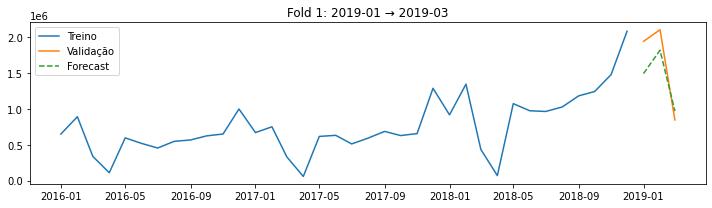

18:38:38 - cmdstanpy - INFO - Chain [1] start processing
18:38:38 - cmdstanpy - INFO - Chain [1] done processing


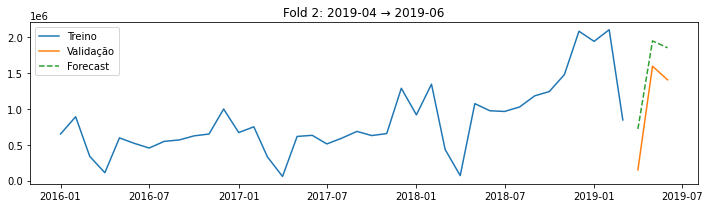

18:38:39 - cmdstanpy - INFO - Chain [1] start processing
18:38:39 - cmdstanpy - INFO - Chain [1] done processing


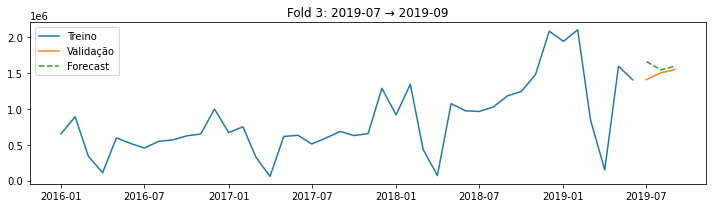

18:38:39 - cmdstanpy - INFO - Chain [1] start processing
18:38:40 - cmdstanpy - INFO - Chain [1] done processing


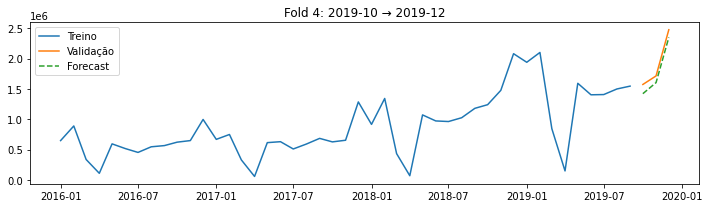

18:38:40 - cmdstanpy - INFO - Chain [1] start processing
18:38:40 - cmdstanpy - INFO - Chain [1] done processing


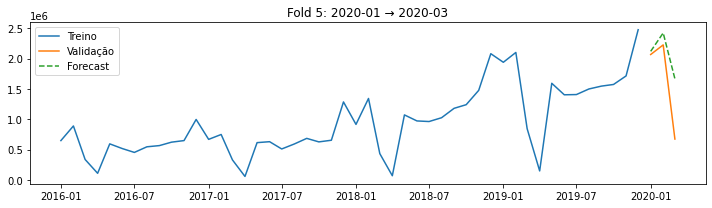

18:38:41 - cmdstanpy - INFO - Chain [1] start processing
18:38:41 - cmdstanpy - INFO - Chain [1] done processing


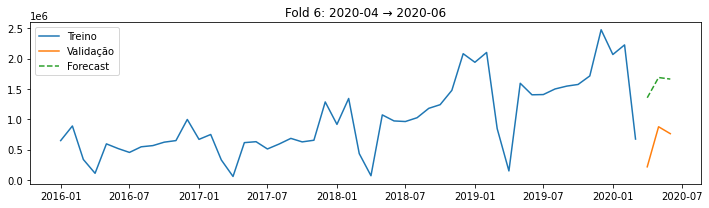

18:38:42 - cmdstanpy - INFO - Chain [1] start processing
18:38:42 - cmdstanpy - INFO - Chain [1] done processing


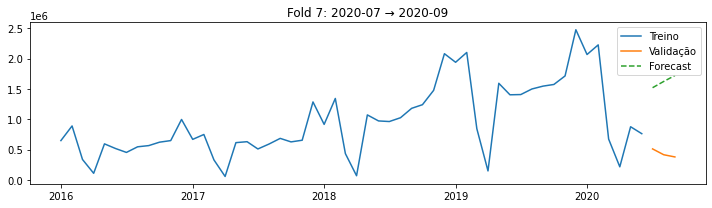

In [0]:
for i, (train_end, val_start, val_end) in enumerate(folds, start=1):
    train = df[df['ds'] <= train_end]
    val   = df[(df['ds'] >= val_start) & (df['ds'] <= val_end)]
    
    model = Prophet(yearly_seasonality=True)
    model.add_country_holidays(country_name='US')
    model.fit(train)
    
    forecast = model.predict(val[['ds']])
    
    plt.figure(figsize=(10, 3))
    plt.plot(train['ds'], train['y'], label='Treino')
    plt.plot(val['ds'], val['y'], label='Validação')
    plt.plot(val['ds'], forecast['yhat'], '--', label='Forecast')
    plt.title(f'Fold {i}: {val_start[:7]} → {val_end[:7]}')
    plt.legend()
    plt.tight_layout()
    plt.show()



## 6. Conclusões
- **Período estável (Folds 1–2, Jan/2019–Jun/2019)**  
  - **SARIMA**: R² = 0,67 / 0,71 · MAE = 263 918 / 274 632  
  - **Prophet (com feriados)**: R² = 0,68 / 0,47 · MAE = 285 896 / 456 429  
  → SARIMA teve melhor desempenho geral, com menor erro absoluto e maior explicabilidade no 2º trimestre.

- **Baixa variabilidade (Fold 3, Jul–Set/2019)**  
  - **SARIMA**: R² = 0,01 · MAE = 44 218  
  - **Prophet (com feriados)**: R² = –5,74 · MAE = 113 565  
  → SARIMA se ajustou melhor à estabilidade do período; Prophet superestimou.

- **Sazonalidade bem definida (Fold 4, Out–Dez/2019)**  
  - **SARIMA**: R² = 0,89 · MAE = 111 838  
  - **Prophet (com feriados)**: R² = 0,89 · MAE = 129 925  
  → Desempenho semelhante em R², mas SARIMA com menor MAE.

- **Início da ruptura (Fold 5, Jan–Mar/2020)**  
  - **SARIMA**: R² = 0,83 · MAE = 261 711  
  - **Prophet (com feriados)**: R² = 0,29 · MAE = 414 402  
  → SARIMA manteve robustez frente à transição da pandemia.

- **Período de ruptura forte (Folds 6–7, Abr–Set/2020)**  
  - Ambos os modelos falharam, com R² negativos acentuados (SARIMA: –3,16 / –429,29 · Prophet: –10,09 / –456,15)  

## 7. Considerações Finais e Recomendação de Modelo

- O objetivo deste projeto foi identificar o modelo com melhor desempenho preditivo para a série mensal de vendas agregadas (`sales_monthly`).

- **SARIMA apresentou o melhor desempenho geral**, com:
  - **Menor MAE em todos os folds de 2019 e início de 2020**
  - **Maior R² em 4 dos 5 folds estáveis**, indicando maior capacidade explicativa

- O **Prophet, mesmo com feriados modelados, não superou o SARIMA** nos períodos em que havia padrão claro de tendência e sazonalidade.

- **Durante a pandemia, ambos os modelos tiveram desempenho insatisfatório**, com R² fortemente negativo e altos erros absolutos — comportamento esperado frente a rupturas não modeladas.

- **Recomendação final**:  
  - **SARIMA será promovido a modelo de produção para a série `sales_monthly`**, por apresentar o melhor desempenho nos períodos estáveis.
  
